
# Random Forest — Seleção de Analista Financeiro

Notebook educativo para o curso **Introdução ao Machine Learning com Python (UNIVALI)**.

**Objetivo:** aplicar **Random Forest** ao dataset de seleção de candidatos e,
de forma didática, **visualizar Bootstrap/OOB**, **métricas de qualidade** e **importância média das features**.



## O que você vai ver
1. Leitura do CSV e visão rápida dos dados  
2. Conceitos práticos: **Bootstrap** e **Out-of-Bag (OOB)**  
3. Treino de **RandomForestClassifier** (com `oob_score=True`)  
4. **Indicadores de qualidade** (Accuracy, Precisão, Recall, F1, ROC-AUC)  
5. **OOB score** e `oob_decision_function_`  
6. **Importância média das features** (MDI)  
7. Experimentos: variar **`n_estimators`** e **`max_features`**


In [1]:
# Importação das bibliotecas necessárias
import numpy as np, pandas as pd, matplotlib.pyplot as plt  # Bibliotecas para manipulação de dados e visualização
from sklearn.model_selection import train_test_split        # Para dividir os dados em treino e teste
from sklearn.preprocessing import OneHotEncoder            # Para codificar variáveis categóricas
from sklearn.compose import ColumnTransformer             # Para aplicar diferentes transformações em diferentes colunas
from sklearn.pipeline import Pipeline                     # Para criar um pipeline de processamento
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc  # Métricas
from sklearn.ensemble import RandomForestClassifier       # O classificador Random Forest

# Configuração dos parâmetros de visualização do matplotlib
plt.rcParams['figure.figsize'] = (10, 6)  # Define o tamanho padrão das figuras
plt.rcParams['axes.grid'] = True          # Ativa a grade nos gráficos

# Leitura do arquivo CSV
csv_path = r"../Datasets/candidatos_financeiro.csv"
df = pd.read_csv(csv_path)
display(df.head())  # Mostra as primeiras linhas do DataFrame

,experiencia_anos,certificacao_financeira,ingles,excel_avancado,formacao,raciocinio_logico,salario_pretendido,comunicacao,disponibilidade_imediata,selecionado
0,5.6,0,Básico,0,Contabilidade,51.0,5860.0,5.0,1,0
1,4.2,1,Básico,0,Engenharia,89.0,6520.0,3.0,0,0
2,5.9,0,Básico,0,Administração,83.0,6270.0,4.0,0,0
3,7.9,1,Básico,1,Engenharia,70.0,5470.0,4.0,1,1
4,4.0,0,Avançado,1,Contabilidade,74.0,4960.0,4.0,1,1


## 1) Entendendo os dados

In [2]:
# Mostra estatísticas descritivas para todas as colunas do DataFrame
display(df.describe(include='all'))

# Exibe as dimensões do DataFrame (número de linhas e colunas)
print("Dimensões:", df.shape)

# Calcula e exibe a proporção de candidatos selecionados
print("Taxa de selecionados:", df['selecionado'].mean())

,experiencia_anos,certificacao_financeira,ingles,excel_avancado,formacao,raciocinio_logico,salario_pretendido,comunicacao,disponibilidade_imediata,selecionado
count,160.000000,160.000000,160,160.000000,160,160.000000,160.000000,160.000000,160.000000,160.000000
unique,NaN,NaN,3,NaN,4,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Básico,NaN,Administração,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,66,NaN,48,NaN,NaN,NaN,NaN,NaN
mean,4.359375,0.537500,NaN,0.425000,NaN,70.887500,5352.562500,3.556250,0.525000,0.381250
std,2.036809,0.500157,NaN,0.495895,NaN,12.289991,959.466733,0.916288,0.500943,0.487219
min,0.000000,0.000000,NaN,0.000000,NaN,39.000000,3010.000000,1.000000,0.000000,0.000000
25%,3.000000,0.000000,NaN,0.000000,NaN,64.000000,4677.500000,3.000000,0.000000,0.000000
50%,4.400000,1.000000,NaN,0.000000,NaN,70.500000,5355.000000,4.000000,1.000000,0.000000
75%,5.525000,1.000000,NaN,1.000000,NaN,79.000000,5980.000000,4.000000,1.000000,1.000000


Dimensões: (160, 10)
Taxa de selecionados: 0.38125



## 2) Bootstrap & OOB na prática
- **Bootstrap:** amostra com reposição por árvore.
- **OOB (Out-of-Bag):** registros não usados no treino da árvore são testados por ela. 
Ativamos com `oob_score=True`.


In [3]:
# Separa as features (X) e o target (y)
X = df.drop(columns=['selecionado'])  # Remove a coluna target
y = df['selecionado']                 # Seleciona apenas a coluna target

# Define as colunas categóricas que precisarão ser codificadas
cat_cols = ['ingles','formacao']

# Cria um transformador para fazer one-hot encoding das variáveis categóricas
pre = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
], remainder='passthrough')  # 'passthrough' mantém as outras colunas inalteradas

# Divide os dados em conjuntos de treino e teste
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y,
    test_size=0.25,      # 25% dos dados para teste
    random_state=42,     # Fixa a semente aleatória
    stratify=y          # Mantém a proporção das classes
)

# Cria e treina o pipeline com pré-processamento e Random Forest
rf = Pipeline([
    ('pre', pre),  # Pré-processamento
    ('clf', RandomForestClassifier(
        n_estimators=50,    # Número de árvores
        max_features='sqrt', # Número de features por split, sendo sqrt o padrão para classificação de classes binárias (raiz quadrada do número total de features)
        bootstrap=True,      # Usa bootstrap
        oob_score=True,      # Calcula score OOB
        random_state=42      # Fixa semente aleatória      
        ))     
])
rf.fit(X_tr, y_tr)  # Treina o modelo

# Extrai o classificador do pipeline
clf = rf.named_steps['clf']

# Exibe o score OOB (Out-of-Bag)
print("OOB Score:", round(clf.oob_score_, 4))

OOB Score: 0.7667


## Visualização das Árvores de Decisão
Vamos visualizar as 5 primeiras árvores do nosso Random Forest para entender como elas tomam decisões diferentes.

<Figure size 2000x2500 with 0 Axes>

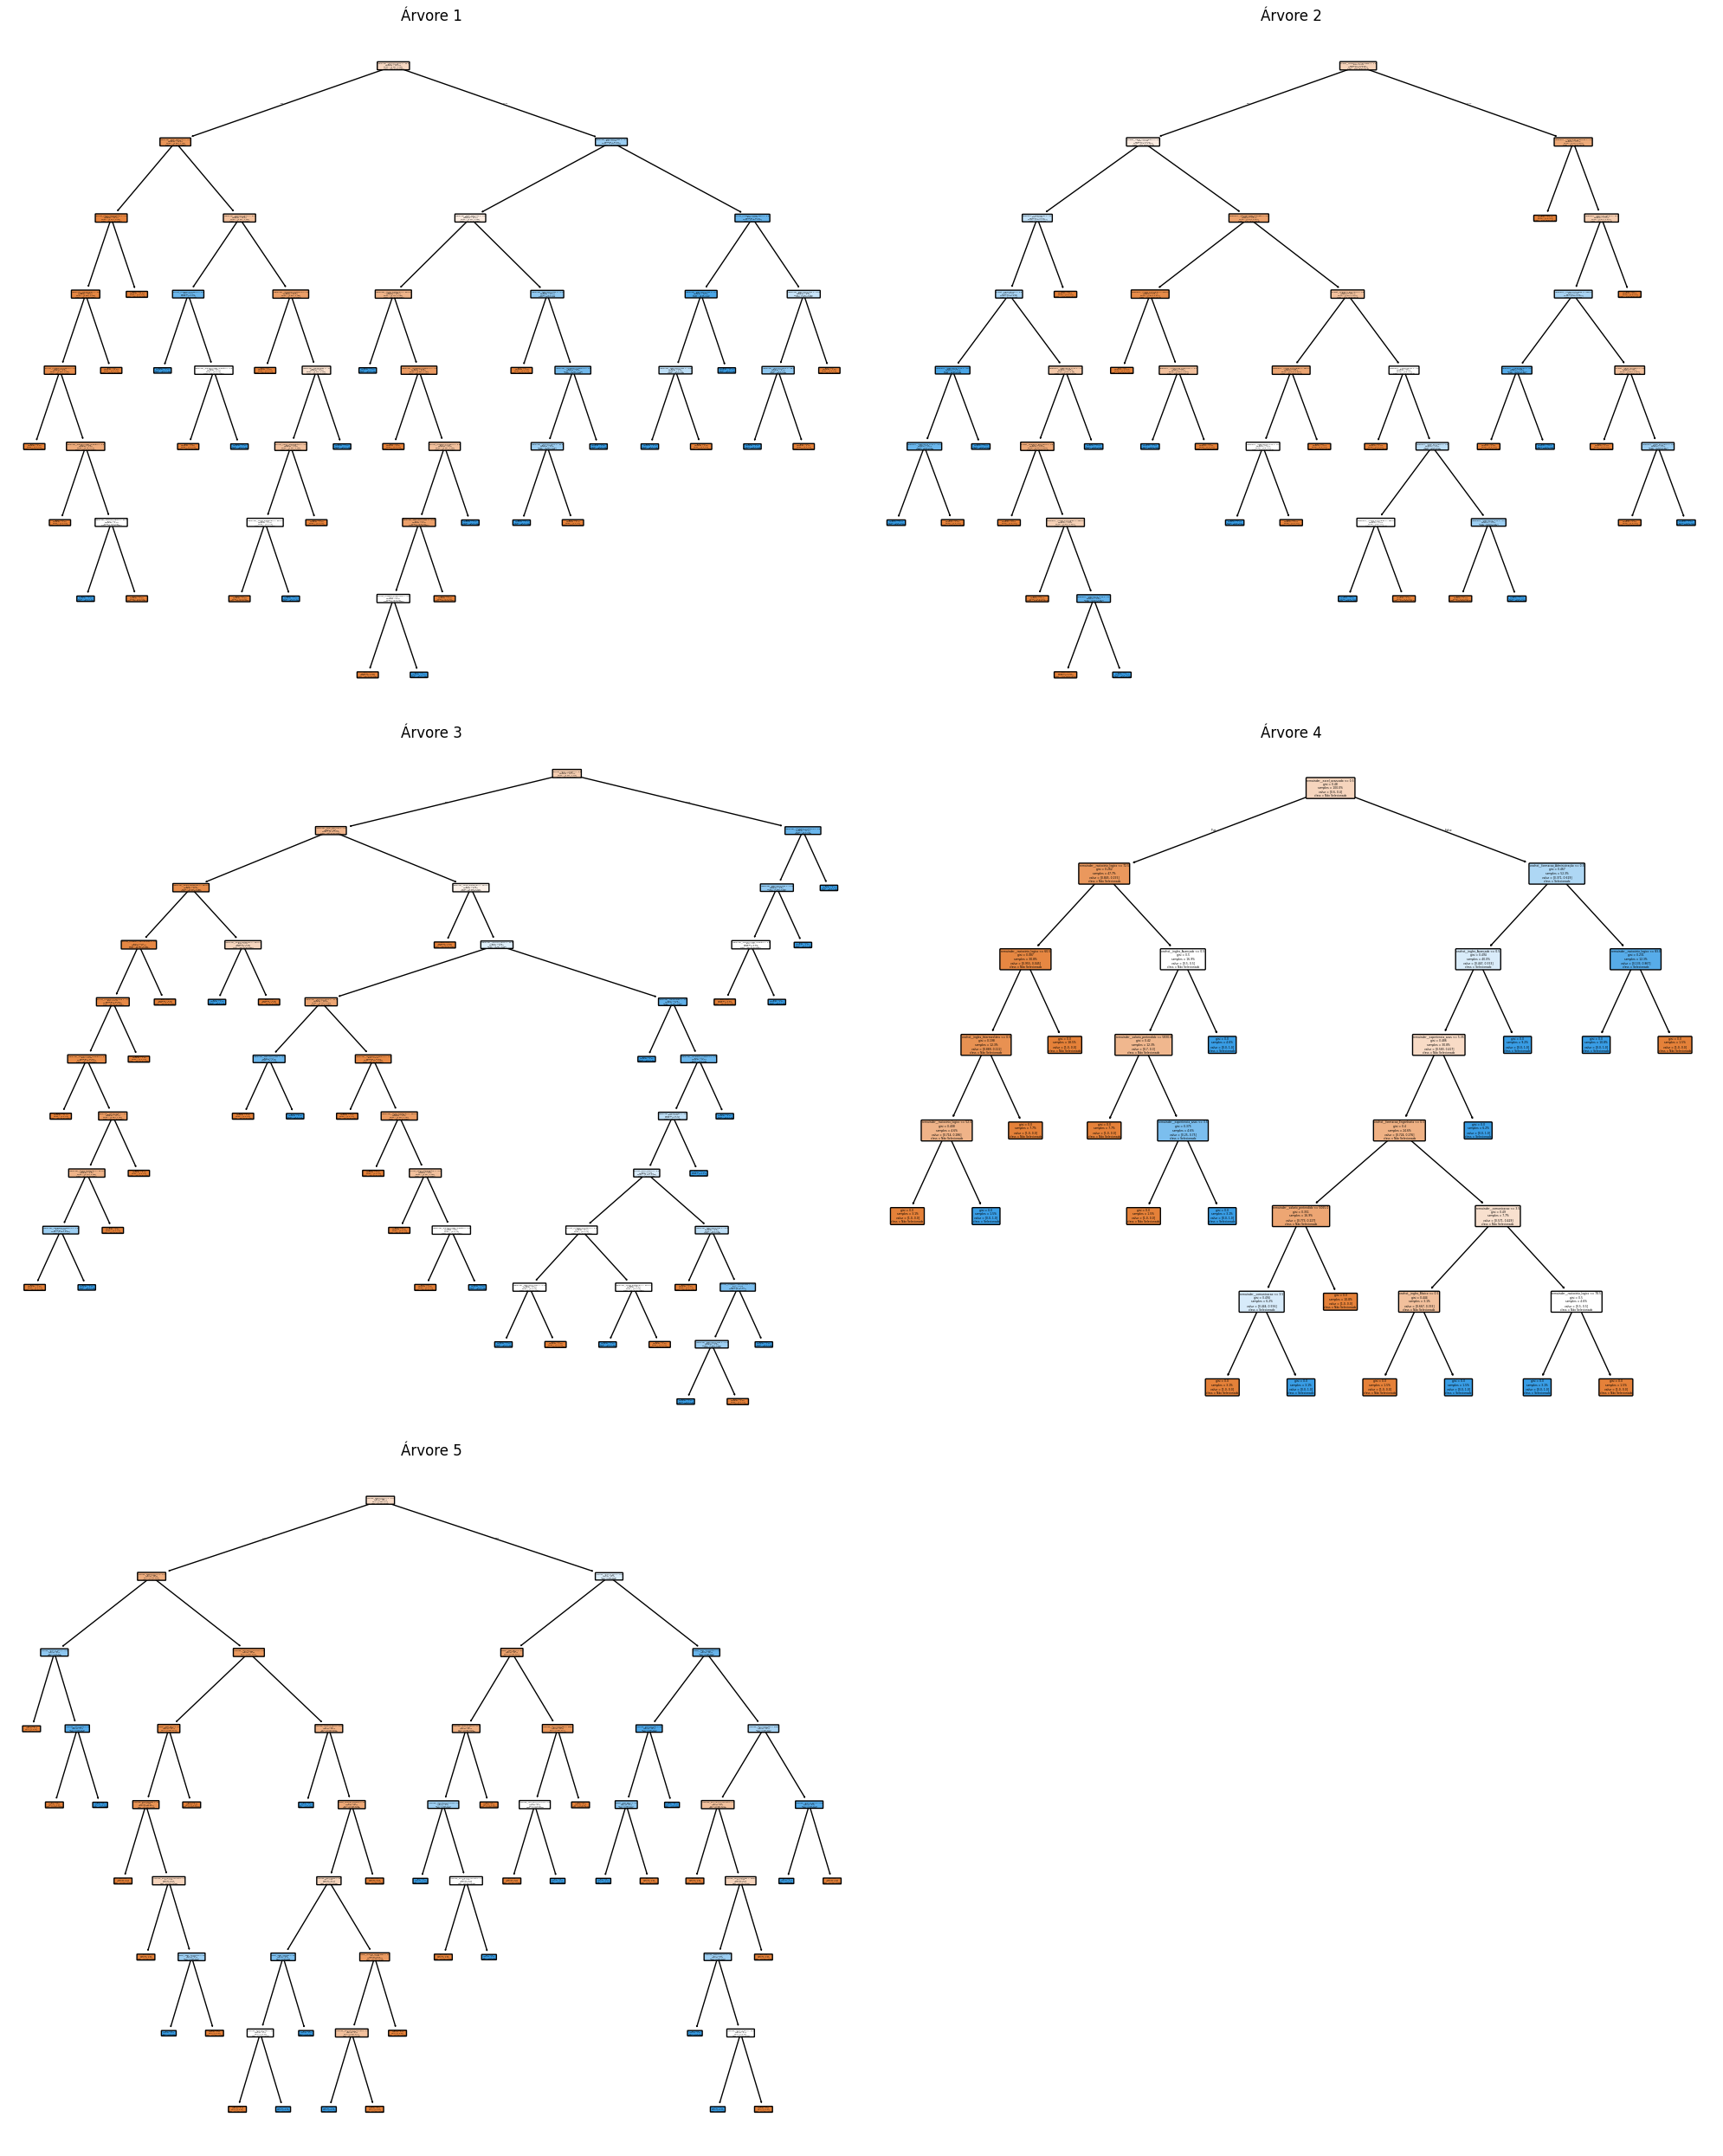

In [4]:
from sklearn.tree import plot_tree

# Obtém os nomes das features para usar nos plots
feature_names = pre.get_feature_names_out()

# Configura o tamanho da figura para mostrar as 5 árvores
plt.figure(figsize=(20, 25))
trees = clf.estimators_  # lista de DecisionTreeClassifier

plt.figure(figsize=(20, 25))
for idx, est in enumerate(trees[:5], start=1): # Plota as primeiras 5 árvores
    ax = plt.subplot(3, 2, idx)# Organiza os subplots em 3 linhas e 2 colunas
    plot_tree(clf.estimators_[idx],
                  feature_names=feature_names,
                  class_names=['Não Selecionado', 'Selecionado'],
                  filled=True,     # Colore os nós baseado na classe majoritária
                  rounded=True,    # Arredonda as bordas dos nós
                  proportion=True  # Mostra as proporções em vez de contagens
                  )
    plt.title(f'Árvore {idx}')

plt.tight_layout()  # Ajusta o espaçamento entre os subplots
plt.show()


## 3) Indicadores de qualidade no conjunto de teste

Acurácia=0.850 | Precisão=0.846 | Recall=0.733 | F1=0.786
Matriz de confusão:
 [[23  2]
 [ 4 11]]


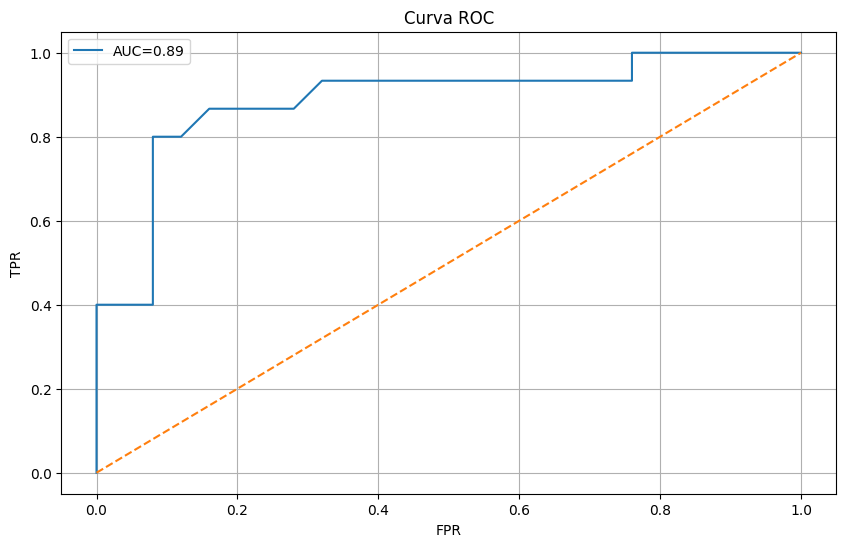

In [5]:
# Faz predições no conjunto de teste
y_pred = rf.predict(X_te)                # Predições das classes
y_prob = rf.predict_proba(X_te)[:,1]     # Probabilidades da classe positiva [:,1] diz respeito à segunda coluna do output de predict_proba

# Calcula várias métricas de avaliação
acc = accuracy_score(y_te, y_pred)       # Acurácia
prec = precision_score(y_te, y_pred)     # Precisão
rec = recall_score(y_te, y_pred)         # Recall
f1 = f1_score(y_te, y_pred)             # F1-Score

# Exibe todas as métricas calculadas
print(f"Acurácia={acc:.3f} | Precisão={prec:.3f} | Recall={rec:.3f} | F1={f1:.3f}")

# Calcula e exibe a matriz de confusão
cm = confusion_matrix(y_te, y_pred)
print("Matriz de confusão:\n", cm)

# Calcula e plota a curva ROC
fpr, tpr, _ = roc_curve(y_te, y_prob)    # Calcula pontos da curva ROC
roc_auc = auc(fpr, tpr)                  # Calcula área sob a curva ROC
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.2f}")  # Plota curva ROC
plt.plot([0,1],[0,1],'--')               # Adiciona linha de referência
plt.xlabel("FPR"); plt.ylabel("TPR")      # Rótulos dos eixos
plt.title("Curva ROC")                    # Título do gráfico
plt.legend(); plt.show()                  # Mostra a legenda e o gráfico

## 4) Importância média das features (MDI)

experiencia_anos            0.170316
raciocinio_logico           0.158013
salario_pretendido          0.126375
excel_avancado              0.116206
ingles_Avançado             0.092476
certificacao_financeira     0.071799
comunicacao                 0.069099
disponibilidade_imediata    0.045951
ingles_Intermediário        0.043012
ingles_Básico               0.026243
formacao_Contabilidade      0.024761
formacao_Engenharia         0.023338
formacao_Economia           0.018979
formacao_Administração      0.013435
dtype: float64

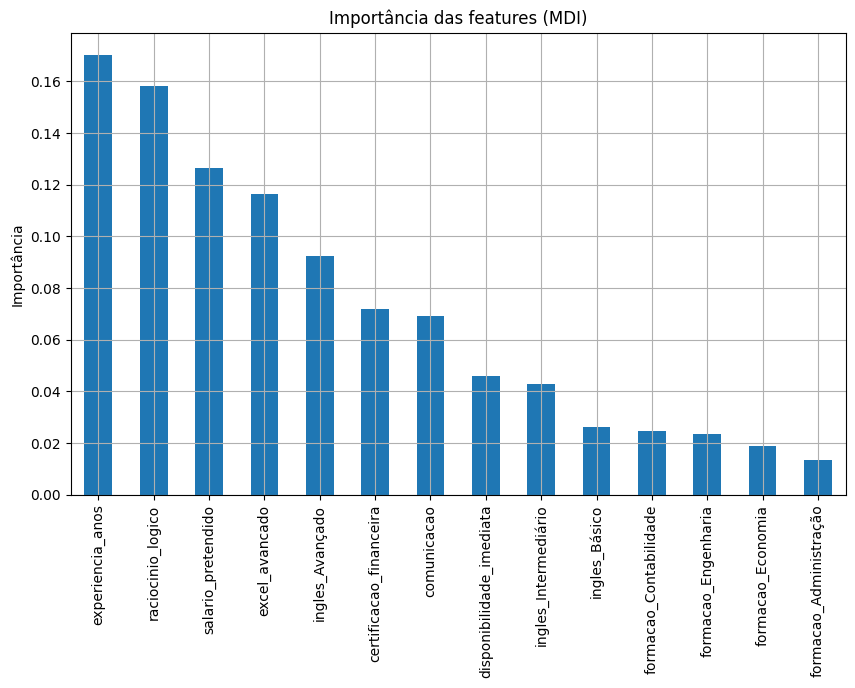

In [6]:
# Obtém os nomes das features após one-hot encoding
oh = rf.named_steps['pre'].named_transformers_['onehot']  # Acessa o transformador one-hot
oh_feats = list(oh.get_feature_names_out(['ingles','formacao']))  # Obtém nomes das features categóricas

# Obtém nomes das features numéricas
num_feats = [c for c in X.columns if c not in ['ingles','formacao']]

# Combina todos os nomes das features
feature_names = oh_feats + num_feats

# Cria uma série pandas com a importância de cada feature
imp = pd.Series(clf.feature_importances_, index=feature_names).sort_values(ascending=False)
display(imp.head(15))  # Mostra as 15 features mais importantes

# Plota um gráfico de barras com as importâncias
imp.head(15).plot(kind='bar')
plt.title("Importância das features (MDI)")  # MDI = Mean Decrease in Impurity
plt.ylabel("Importância")
plt.show()

## 5) Experimento: variar `n_estimators`

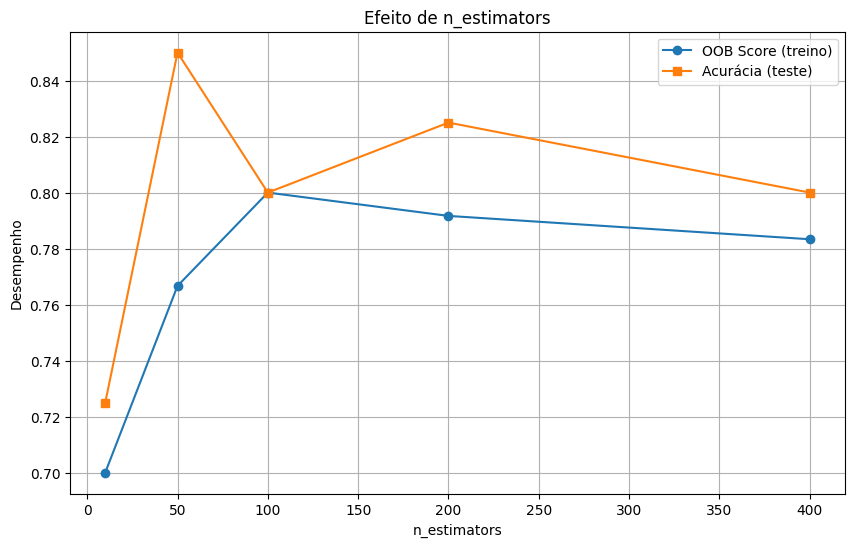

In [7]:
# Define diferentes valores para n_estimators (número de árvores)
vals = [10, 50, 100, 200, 400]
oob_scores = []  # Lista para armazenar os scores OOB
test_acc = []    # Lista para armazenar as acurácias no teste

# Testa cada valor de n_estimators
for n in vals:
    # Cria e treina o modelo com o número atual de árvores
    model = Pipeline([
        ('pre', pre),
        ('clf', RandomForestClassifier(
            n_estimators=n,       # Número de árvores variável
            max_features='sqrt',  # Usa sqrt(n_features) features por split
            bootstrap=True,       # Habilita bootstrap
            oob_score=True,      # Calcula score OOB
            random_state=42     # Fixa semente aleatória
            ))
    ])
    model.fit(X_tr, y_tr)
    
    # Extrai o classificador e armazena o score OOB
    clf_n = model.named_steps['clf']
    oob_scores.append(clf_n.oob_score_)
    
    # Faz predições e calcula acurácia no teste
    y_pred_n = model.predict(X_te)
    test_acc.append(accuracy_score(y_te, y_pred_n))

# Plota os resultados
plt.plot(vals, oob_scores, marker='o', label='OOB Score (treino)')
plt.plot(vals, test_acc, marker='s', label='Acurácia (teste)')
plt.xlabel("n_estimators")        # Rótulo do eixo x
plt.ylabel("Desempenho")         # Rótulo do eixo y
plt.title("Efeito de n_estimators")  # Título do gráfico
plt.legend(); plt.show()         # Mostra a legenda e o gráfico

🔹 OOB alto e teste baixo = modelo superajustado (overfitting)

🔹 OOB e teste próximos = bom generalizador (ideal)

🔹 OOB baixo e teste alto = acaso ou pouca amostra

## 6) Comparando `max_features`

In [8]:
# Define as configurações para testar diferentes valores de max_features
settings = [('sqrt','SQRT'), (None,'ALL')]  # Lista de tuplas com (valor max_features, nome para identificação)
res = []  # Lista para armazenar os resultados dos experimentos

# Loop através das diferentes configurações de max_features
for mf, tag in settings:
    # Cria um pipeline com pré-processamento e Random Forest
    model = Pipeline([
        ('pre', pre),  # Usa o pré-processador definido anteriormente
        ('clf', RandomForestClassifier(
            n_estimators=200,     # Número de árvores na floresta
            max_features=mf,      # Número de features a considerar em cada split (sqrt ou todas)
            bootstrap=True,       # Habilita bootstrap para cada árvore
            oob_score=True,       # Calcula score out-of-bag
            random_state=42      # Fixa a semente aleatória para reprodutibilidade
        ))       
    ])
    
    # Treina o modelo com os dados de treino
    model.fit(X_tr, y_tr)
    
    # Extrai o classificador Random Forest do pipeline
    clf_m = model.named_steps['clf']
    
    # Faz predições no conjunto de teste
    y_pred_m = model.predict(X_te)
    
    # Calcula a acurácia no conjunto de teste
    acc_m = accuracy_score(y_te, y_pred_m)
    
    # Armazena os resultados (configuração, score OOB, acurácia no teste)
    res.append((tag, clf_m.oob_score_, acc_m))

# Cria um DataFrame com os resultados para melhor visualização
pd.DataFrame(res, columns=['config','OOB','ACC_teste'])  # Exibe os resultados em formato tabular

,config,OOB,ACC_teste
0,SQRT,0.791667,0.825
1,ALL,0.750000,0.850


## 7) Testando o modelo com novos candidatos
Vamos criar alguns perfis fictícios de candidatos e ver como o modelo prevê suas chances de seleção.

In [9]:

# ---------- 1) Candidato de teste ----------
candidate_full = {
    "experiencia_anos": 4,
    "certificacao_financeira": 1,
    "ingles": "Intermediário",
    "excel_avancado": 0,
    "formacao": "Contabilidade",
    "raciocinio_logico": 8.0,
    "salario_pretendido": 4500.0,
    "comunicacao": 7.5,
    "disponibilidade_imediata": 0
}

novo_candidato = pd.DataFrame([candidate_full])

print("=== Perfil do Candidato ===")
display(novo_candidato)

# ---------- 2) Predição para o candidato ----------
# rf é o seu Pipeline já treinado: rf.fit(X_tr, y_tr)
prob = rf.predict_proba(novo_candidato)[0, 1]
pred = rf.predict(novo_candidato)[0]
print(f"Probabilidade de ser selecionado: {prob:.2%}")
print("Predição final:", "Selecionado" if pred==1 else "Não Selecionado")

=== Perfil do Candidato ===


,experiencia_anos,certificacao_financeira,ingles,excel_avancado,formacao,raciocinio_logico,salario_pretendido,comunicacao,disponibilidade_imediata
0,4,1,Intermediário,0,Contabilidade,8.0,4500.0,7.5,0


Probabilidade de ser selecionado: 16.00%
Predição final: Não Selecionado
